#Real_time_Application_for_Solar_ee_cu_by_using_rnn


# import  library

In [0]:
# import neccessary library
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

# 1. Load_data_for_forecast

## 3. Prepare input of time series

In [0]:
def get_batch(X_origin, steps, start_indices):
    '''
    This method will generate input and output of time-series for RNN, for example
    input --> x(t-2) x(t-1) x(t)
    target --> x(t-1) x(t) x(t+1)
    '''
    X = X_origin.copy()
    
    start = start_indices[0]
    train_batch = np.array(X[start:start+steps+1, :]).reshape(steps+1, 20)
    
    train_return = train_batch[:-1,:-8].reshape(-1, steps, 12) #train_batch[:-1,:-5]
    target_return = train_batch[1:,-8:].reshape(-1, steps, 8) # train_batch[1:,-5:]
    
    for k, start in enumerate(start_indices):
        
        if k != 0:
            train_batch = np.array(X[start:start+steps+1, :]).reshape(steps+1, 20)[:-1,:-8].reshape(-1, steps, 12)
            target_batch = np.array(X[start:start+steps+1, :]).reshape(steps+1, 20)[1:,-8:].reshape(-1, steps, 8)
            train_return = np.concatenate((train_return, train_batch), axis = 0)
            target_return = np.concatenate((target_return, target_batch), axis = 0)
    
    return train_return, target_return

In [0]:
data_train = pd.read_csv('EE_CU_Train_2017.csv')
data_train.drop(('date_time'), axis=1, inplace=True)

In [0]:
data_test = pd.read_csv('EE_CU_Test_2018.csv')
data_test.drop(('date_time'), axis=1, inplace=True)

In [6]:
# split train and test set
#test_set_ratio = 0.05
#full_len = solar_mat.shape[0]

#len_train = round(full_len*(1-test_set_ratio))

solar_train_origin = data_train.as_matrix().copy() #Solar_input -->ggg
solar_test_origin = data_test.as_matrix().copy() #Solar_input -->ggg

len_train = solar_train_origin.shape[0]
len_test = solar_test_origin.shape[0]
full_len = len_train+len_test

print('data train shape', len(solar_train_origin))
print('data test shape', len(solar_test_origin))

data train shape 17520
data test shape 8688


In [7]:
type(solar_train_origin)

numpy.ndarray

In [0]:
full_len

31294

In [0]:
solar_train_origin_data = pd.DataFrame(solar_train_origin)

In [0]:
solar_train_origin_data.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.195985,0.196503,0.19591,0.196168,0.197086,0.195375,0.195824,0.196091,0.196212,1.0654,25.138333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
solar_test_origin_data = pd.DataFrame(solar_test_origin)

In [0]:
solar_train_origin_data.shape

(21906, 20)

In [0]:
solar_test_origin_data.shape

(9388, 20)

In [0]:
print(full_len)
print(len_train)

31294
21906


In [8]:
# normalize input
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
solar_train_origin_scale = scaler.fit_transform(solar_train_origin)
solar_test_origin_scale = scaler.transform(solar_test_origin)

scaler.data_min_.shape


(20,)

In [0]:
def inverse_transform(input_, scaler):
    min_data = scaler.data_min_[12]   #index of power in ggg
    max_data = scaler.data_max_[12]
    
    return input_*(max_data - min_data) + min_data
    

In [0]:
output_ = inverse_transform(solar_test_origin_scale[:,-8:], scaler) #4or5 is ok

In [11]:
output_.shape

(8688, 8)

In [12]:
np.sum(output_ - solar_test_origin[:,-8:])

4.5799895993792195e-12

# 4 Model Selection

In [0]:
num_inputs = 12
num_outputs = 8

num_time_steps = 12
forecast_steps = 1

## layers of RNN 
num_layers = 2      
## dropout regularization
keepprob = 0.8         

learning_rate = 0.005
num_neurons = 256
batch_size = 2**5

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.9)


In [0]:
import tensorflow as tf

# RNN
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs], name = 'X')
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs], name = 'Y')
tf_keepprob = tf.placeholder(tf.float32, name='tf_keepprob')

#######################################################################################
## GRUCell regularization
save_name = './GG6_GRU_model'
cells = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.MultiRNNCell(
        [tf.contrib.rnn.DropoutWrapper(
            tf.contrib.rnn.GRUCell(num_neurons, activation = tf.nn.relu,
                                   kernel_initializer = tf.contrib.layers.xavier_initializer()),
            output_keep_prob=tf_keepprob)
         for i in range(num_layers)]), output_size = num_outputs)

#######################################################################################

outputs, states = tf.nn.dynamic_rnn(cells, X, dtype = tf.float32)

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)

train = optimizer.minimize(loss)
init = tf.global_variables_initializer()

saver = tf.train.Saver()

In [0]:
outputs

<tf.Tensor 'rnn/transpose_1:0' shape=(?, 12, 8) dtype=float32>

In [17]:
## Train RNN model

num_epochs = 2

with tf.Session(config = tf.ConfigProto(gpu_options = gpu_options)) as sess:
    
    sess.run(init)
    
    count = 0
    for i in range(num_epochs):
        
        solar_train = solar_train_origin_scale.copy()
        
        rand_start = np.random.permutation(len_train-num_time_steps)
        avg_mse = 0
        
        for k in range(0, len_train-num_time_steps, batch_size):
            
            count = count + 1
            
            start = rand_start[k:k+batch_size]
            X_batch, y_batch = get_batch(solar_train_origin_scale, num_time_steps, start)
            sess.run(train, feed_dict={X:X_batch, y:y_batch, tf_keepprob:keepprob}) 
            y_pred = sess.run(outputs, feed_dict={X:X_batch, tf_keepprob:keepprob})
            avg_mse += loss.eval(feed_dict={X:X_batch, y:y_batch, tf_keepprob:keepprob})
        
        avg_mse /= len(rand_start)
        
        if i%1 == 0:
            print('epoch: {:3d}\tMSE = {:.6f}'.format(i, avg_mse))

    # Save Model for Later
    saver.save(sess, save_name)

epoch:   0	MSE = 0.000158
epoch:   1	MSE = 0.000095


#forcast 1 step ahead evaluation

In [0]:
solar_train = solar_test_origin_scale.copy()

In [23]:
## Train Forecast steps evaluation

with tf.Session() as sess:
    
    saver.restore(sess, save_name)
    
    train_seed = solar_train_origin_scale[:num_time_steps,:].copy()
    y_train_prediction = []
    
    avg_mse = 0
    count = 0

    for k in range(num_time_steps, solar_train.shape[0]-1):

        last_train = np.array(train_seed[-num_time_steps:,:-8]).reshape(-1, num_time_steps, 12).copy()
        y_pred = sess.run(outputs, feed_dict={X:last_train, tf_keepprob:1})
            
        train_seed = solar_train_origin_scale[:k+1, :].copy()
            
        y_train_prediction.append(y_pred[0, -1, :])
        
    print('Complete')

INFO:tensorflow:Restoring parameters from ./GG6_GRU_model
Complete


In [0]:
type(np.array(y_train_prediction))

numpy.ndarray

In [25]:
# evaluate on train set
y_train_rescale = inverse_transform(np.array(y_train_prediction) , scaler)
solar_train_rescale = inverse_transform(solar_test_origin_scale[:,-8:] , scaler)

rmse = np.sqrt(np.mean(np.square(y_train_rescale - solar_train_rescale[num_time_steps+1:])))
#rmse = (rmse/500)*100
print('RMSE = {:.6f}'.format(rmse))

RMSE = 0.912168


In [0]:
y_train_rescale_df = pd.DataFrame(y_train_rescale)
solar_train_rescale_df = pd.DataFrame(solar_train_rescale[num_time_steps+1:])

In [0]:
from google.colab import files

y_train_rescale_df.to_csv('y_train_rescale_df.csv')
files.download('y_train_rescale_df.csv')

In [0]:
from google.colab import files

solar_train_rescale_df.to_csv('solar_train_rescale_df.csv')
files.download('solar_train_rescale_df.csv')

In [0]:
y_train_rescale

array([[5.7870317, 1.5754732, 2.5629578, ..., 5.8784556, 6.4904256,
        7.665682 ],
       [5.8254538, 1.6089488, 2.5633104, ..., 5.879209 , 6.499544 ,
        7.677067 ],
       [5.8435674, 1.616888 , 2.547247 , ..., 5.8656006, 6.488329 ,
        7.6660943],
       ...,
       [4.3143516, 0.6303997, 2.4643323, ..., 5.641222 , 5.9803896,
        7.03434  ],
       [4.726379 , 0.9115323, 2.6166399, ..., 5.8245173, 6.2387953,
        7.32853  ],
       [4.8996577, 1.0117627, 2.6554956, ..., 5.883797 , 6.325639 ,
        7.4309416]], dtype=float32)

In [0]:
solar_test = solar_test_origin_scale.copy()

In [0]:
## Train Forecast steps evaluation

with tf.Session() as sess:
    
    saver.restore(sess, save_name)
    
    test_seed = solar_test_origin_scale[:num_time_steps,:].copy()
    y_test_prediction = []
    
    avg_mse = 0
    count = 0

    for k in range(num_time_steps, solar_test.shape[0]-1):

        last_test = np.array(test_seed[-num_time_steps:,:-8]).reshape(-1, num_time_steps, 12).copy()
        y_pred = sess.run(outputs, feed_dict={X:last_test, tf_keepprob:1})
            
        test_seed = solar_test_origin_scale[:k+1, :].copy()
            
        y_test_prediction.append(y_pred[0, -1, :])
        
    print('Complete')

INFO:tensorflow:Restoring parameters from ./GG6_GRU_model
Complete


In [0]:
# evaluate on train set
y_test_rescale = inverse_transform(np.array(y_test_prediction) , scaler)
solar_test_rescale = inverse_transform(solar_test_origin_scale[:,-8:] , scaler)

rmse = np.sqrt(np.mean(np.square(y_test_rescale - solar_test_rescale[num_time_steps+1:])))
print('RMSE = {:.6f}'.format(rmse))

RMSE = 37.427675


In [0]:
y_test_rescale_df = pd.DataFrame(y_test_rescale)
solar_test_rescale_df = pd.DataFrame(solar_test_rescale[num_time_steps+1:])

In [0]:
y_test_rescale_df.head(2)

,0,1,2,3,4,5,6,7
0,54.437458,36.525585,20.742157,8.829308,2.967876,1.862787,2.583335,3.070341
1,35.530033,19.981693,8.742180,2.319249,0.556192,1.204012,2.066286,2.398671


In [0]:
solar_test_rescale_df.head(2)

,0,1,2,3,4,5,6,7
0,47.541667,20.1778,7.8672,0.02,0.0,0.0,0.0,0.0
1,20.177800,7.8672,0.0200,0.00,0.0,0.0,0.0,0.0


In [0]:
from google.colab import files

y_test_rescale_df.to_csv('y_test_rescale_df.csv')
files.download('y_test_rescale_df.csv')

In [0]:
from google.colab import files

solar_test_rescale_df.to_csv('solar_test_rescale_df.csv')
files.download('solar_test_rescale_df.csv')

In [0]:
y_test_rescale.shape

In [0]:
y_test_rescale

In [0]:
solar_test_rescale[num_time_steps+1:]

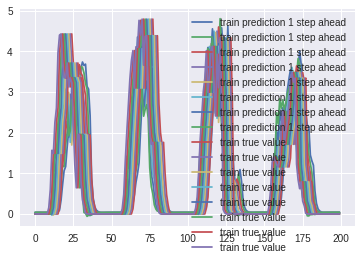

In [26]:
plt.plot(y_train_rescale[-1300:-1100], label='train prediction 1 step ahead')
plt.plot(solar_train_rescale[-1300:-1100], label='train true value')
plt.legend()

In [0]:
plt.plot(y_train_rescale[-1300:-1200], label='train prediction 1 step ahead')
plt.plot(solar_train_rescale[-1300:-1200], label='train true value')
plt.legend()

In [0]:
plt.plot(y_train_rescale[-1300:-1250], label='train prediction 1 step ahead')
plt.plot(solar_train_rescale[-1300:-1250], label='train true value')
plt.legend()

In [0]:
plt.plot(y_train_rescale[-1250:-1200], label='train prediction 1 step ahead')
plt.plot(solar_train_rescale[-1250:-1200], label='train true value')
plt.legend()

In [0]:
plt.plot(y_train_rescale[-1550:-1500], label='train prediction 1 step ahead')
plt.plot(solar_train_rescale[-1550:-1500], label='train true value')
plt.legend()